In [1]:
from matcalc.relaxation import RelaxCalc
from matcalc.phonon import PhononCalc
from matcalc.eos import EOSCalc
from matcalc.elasticity import ElasticityCalc
from matcalc.util import get_universal_calculator
from datetime import datetime

from pymatgen.ext.matproj import MPRester

In [2]:
mpr = MPRester()

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


In [3]:
mpdata = mpr.materials._search(nelements=2, fields=["material_id", "structure"])

Retrieving MaterialsDoc documents:   0%|          | 0/20627 [00:00<?, ?it/s]

In [4]:
up = get_universal_calculator("M3GNet")

In [5]:
fmax = 0.1
opt = "BFGSLineSearch"
# The general principle is to do a relaxation first and just reuse the same structure.
prop_calcs = [
    ("relax", RelaxCalc(up, fmax=fmax, optimizer=opt)),
    ("elastic", ElasticityCalc(up, fmax=fmax, relax_structure=False)),
    ("eos", EOSCalc(up, fmax=fmax, relax_structure=False, optimizer=opt)),
    ("phonon", PhononCalc(up, fmax=fmax, relax_structure=False)),
]

In [6]:
data = []

for i, d in enumerate(mpdata):
    s = d.structure
    dd = {"mid": d.material_id, "composition": s.composition.formula, "nsites": len(s)}
    properties = {}
    for name, c in prop_calcs:
        starttime = datetime.now()
        properties[name] = c.calc(s)
        endtime = datetime.now()
        if name == "relax":
            # Replace the structure with the one from relaxation for other property computations.
            s = properties[name]["final_structure"]
        dd[f"time_{name}"] = (endtime - starttime).total_seconds()
    dd["properties"] = properties
    data.append(dd)
    if i == 20:
        # Here we just do a sampling of 20 structures.
        break

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/phonopy/structure/cells.py:1396: UserWarning: Crystal structure is distorted in a tricky way so that phonopy could not handle the crystal symmetry properly. It is recommended to symmetrize crystal structure well and then re-start phonon calculation from scratch.
  warnings.warn(msg)


In [7]:
import pandas as pd

df = pd.DataFrame(data)
df["time_total"] = df["time_relax"] + df["time_elastic"] + df["time_phonon"] + df["time_eos"]

In [8]:
df

,mid,composition,nsites,time_relax,time_elastic,time_eos,time_phonon,properties,time_total
0,mp-1106268,Pr14 Pd6,20,3.624754,0.266705,2.310425,21.074533,{'relax': {'final_structure': [[-5.19201361 2...,27.276417
1,mp-974315,Ru2 I2,4,0.824897,0.179305,1.235350,2.522247,{'relax': {'final_structure': [[ 1.84542095 -1...,4.761799
2,mp-1206714,Al2 Sn1,3,0.156546,0.127533,0.237618,0.249509,{'relax': {'final_structure': [[1.59915279 1.5...,0.771206
3,mp-30339,Er1 Ag2,3,0.098265,0.236556,0.723410,0.748004,{'relax': {'final_structure': [[ 8.89873414e-0...,1.806235
4,mp-696,Si4 Pt4,8,1.081413,0.384058,5.000203,8.099256,{'relax': {'final_structure': [[0.89915742 3.8...,14.564930
5,mp-866222,Ac2 Si6,8,3.799799,0.308640,0.900134,6.487873,{'relax': {'final_structure': [[-5.41563953e-0...,11.496446
6,mp-11422,Gd1 Hg1,2,0.074850,0.113691,0.183954,0.167755,"{'relax': {'final_structure': [[0. 0. 0.] Gd, ...",0.540250
7,mp-21238,Th4 Si4,8,0.800345,0.235167,1.514517,3.016535,{'relax': {'final_structure': [[1.08960316 0.7...,5.566564
8,mp-1215363,Zr4 Pd1,5,0.265478,0.192180,1.178378,2.403731,{'relax': {'final_structure': [[1.68717563e-07...,4.039767
9,mp-1212658,Ga1 C6,7,0.648763,0.215847,1.371010,4.725562,{'relax': {'final_structure': [[-1.88279105e-0...,6.961182


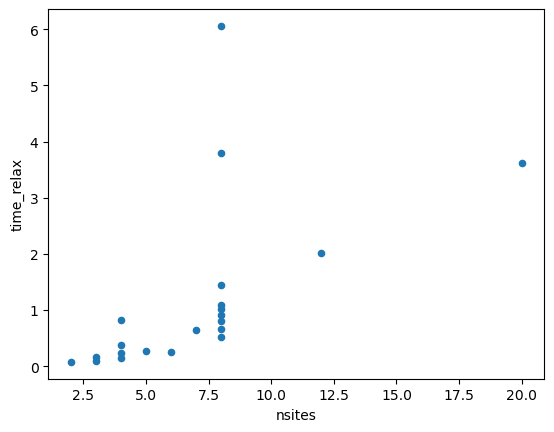

In [9]:
ax = df.plot(x="nsites", y="time_relax", kind="scatter")

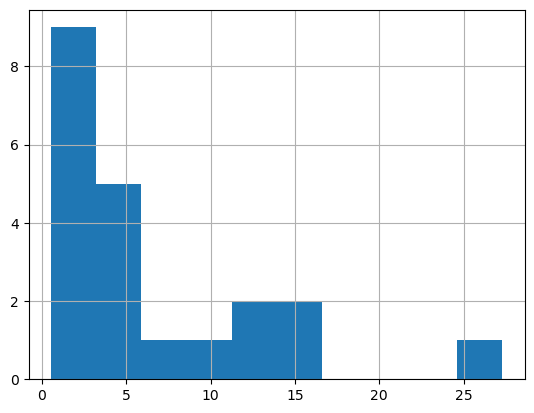

In [10]:
ax = df["time_total"].hist()